# DEEP LEARNING PROJECT 1
---

In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary
import torch
import torch.utils.data as data

## PARAMETERS

In [2]:
INPUT_SIZE = (2, 14, 14)

import torch.nn as nn
import numpy as np

NB_SAMPLES = 1000
DATA_DIR = './data'

NUMBER_OF_CLASSES = 10

WIDTH_HEIGHT = 14
SINGLE_IMAGE_SIZE = WIDTH_HEIGHT * WIDTH_HEIGHT
DOUBLE_IMAGE_SIZE = 2 * SINGLE_IMAGE_SIZE

# ----Train Config-----#
LEARNING_RATE = 0.001
TRAIN_BATCH_SIZE = 5
FINAL_CRITERION = nn.BCELoss()
EPOCHS = 20

# ----Search Config-----#
FCNEURONS = [32,64,128, 256,512]
NB_LAYERS = [1, 2, 3]

#----Test Config-----#
TEST_BATCH_SIZE = NB_SAMPLES

#----BasicNet Config-----#
BASIC_NET_NAME = "basic_net"
BASIC_NET_HIDDEN_LAYER = 128
BASIC_NET_NB_HIDDEN = 1

BASIC_BEST_HIDDEN = 0

# Helpers

In [3]:
############################################# HELPERS ###############################

import torch
from torchvision import datasets
import os
import time
from pathlib import Path


######################################################################
# The data

def convert_to_one_hot_labels(input, target):
    tmp = input.new_zeros(target.size(0), target.max() + 1)
    #set ones
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    return tmp

def load_data(cifar = None, one_hot_labels = False, normalize = False, flatten = True):

    data_dir = './data'

    if (cifar is not None and cifar):
        print('* Using CIFAR')
        cifar_train_set = datasets.CIFAR10(data_dir + '/cifar10/', train = True, download = True)
        cifar_test_set = datasets.CIFAR10(data_dir + '/cifar10/', train = False, download = True)

        train_input = torch.from_numpy(cifar_train_set.data)
        train_input = train_input.transpose(3, 1).transpose(2, 3).float()
        train_target = torch.tensor(cifar_train_set.targets, dtype = torch.int64)

        test_input = torch.from_numpy(cifar_test_set.data).float()
        test_input = test_input.transpose(3, 1).transpose(2, 3).float()
        test_target = torch.tensor(cifar_test_set.targets, dtype = torch.int64)

    else:
        print('* Using MNIST')
        mnist_train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
        mnist_test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)

        train_input = mnist_train_set.data.view(-1, 1, 28, 28).float()
        train_target = mnist_train_set.targets
        test_input = mnist_test_set.data.view(-1, 1, 28, 28).float()
        test_target = mnist_test_set.targets

    if flatten:
        train_input = train_input.clone().reshape(train_input.size(0), -1)
        test_input = test_input.clone().reshape(test_input.size(0), -1)
        
        
    train_input = train_input.narrow(0, 0, 1000)
    train_target = train_target.narrow(0, 0, 1000)
    test_input = test_input.narrow(0, 0, 1000)
    test_target = test_target.narrow(0, 0, 1000)

    print('** Use {:d} train and {:d} test samples'.format(train_input.size(0), test_input.size(0)))

    if one_hot_labels:
        train_target = convert_to_one_hot_labels(train_input, train_target)
        test_target = convert_to_one_hot_labels(test_input, test_target)

    if normalize:
        mu, std = train_input.mean(), train_input.std()
        train_input.sub_(mu).div_(std)
        test_input.sub_(mu).div_(std)

    return train_input, train_target, test_input, test_target

######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):

    data_dir = DATA_DIR

    train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

######################################################################

######################################################################

# Modules

In [4]:
import torch.nn as nn
import torch
from torch.nn import functional as F
import math
import config

class BasicNet(nn.Module):

    def __init__(self, nb_hidden_layers, hidden_layer = config.BASIC_NET_HIDDEN_LAYER):
        super(BasicNet, self).__init__()
        self.model_name = config.BASIC_NET_NAME
        
        if nb_hidden_layers < 1:
            raise Exception("Minimum 1 hidden layers for " + self.model_name)
        
        self.hiddens = nn.ModuleList([nn.Linear(hidden_layer, hidden_layer) for i in range(nb_hidden_layers-1)])
        
        self.hiddens.insert(0, nn.Linear(config.DOUBLE_IMAGE_SIZE, hidden_layer))
        
        self.output = nn.Linear(hidden_layer, 1)

    def forward(self, x):
        flattened = x.view(x.size(0),-1)
        
        hid = flattened
        
        for layer in self.hiddens:
            hid = layer(hid)
            hid = F.relu(hid)
        
        out = self.output(hid)
        
        return torch.sigmoid(out)

# Train & Predict

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR

def train_basic(model, 
                dataloader, 
                test_dataloader,
                epochs = EPOCHS, 
                final_criterion = FINAL_CRITERION, 
                learning_rate=LEARNING_RATE):
    
    cuda = torch.cuda.is_available()
    if cuda:
        model = model.to(device="cuda")
        print("CUDA available")
    else:
        print("NO CUDA")

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    training_losses = []
    training_acc = []
    
    test_losses = []
    test_acc = []

    for epoch in range(1, epochs+1):  
        sum_loss_epoch = 0
        total = 0
        correct = 0
        accuracy_epoch = 0
        
        for ind_batch, sample_batched in enumerate(dataloader):
            
            images = sample_batched["images"]
            labels = sample_batched["bool_labels"]
            
            if cuda:
                images = images.to(device="cuda")
                labels = labels.to(device="cuda")

            optimizer.zero_grad()

            output = model(images)
            
            loss = final_criterion(output.flatten(), labels.float().flatten())

            loss.require_grad = True
            loss.backward()

            optimizer.step()

            #update the accuracy 
            total += images.size(0)  
            correct += (output.round() == labels).sum() 
            
            if ind_batch % 250 == 0:
                print("[Epoch {}, Batch {}/{}]:  [Loss: {:.2f}]".format(epoch, ind_batch, len(dataloader), loss) )
                
            #add the loss for this batch to the total loss of the epoch
            sum_loss_epoch = sum_loss_epoch + loss.item()
            
        #compute the mean to obtain the loss for this epoch 
        mean_loss = sum_loss_epoch / float(len(dataloader))
        
        print("At epoch {0} the loss is {1}".format(epoch, mean_loss) )
        training_losses.append(mean_loss)
        
        accuracy_epoch = float(correct) / float(total)
        print("At epoch {0} the accuracy is {1}".format(epoch, accuracy_epoch) )
        training_acc.append(accuracy_epoch)
        
        test_loss, test_accuracy = predict_basic(model,
                                                 test_dataloader,
                                                 final_criterion)

        test_losses.append(test_loss)
        test_acc.append(test_accuracy)
        
    return training_losses, training_acc, test_losses, test_acc

def predict_basic(model, 
            dataloader,
            final_criterion = FINAL_CRITERION):
    
    model.eval()
    
    cuda = torch.cuda.is_available()
        
    sum_loss = 0
    total = 0
    correct = 0
    accuracy = 0

    for ind_batch, sample_batched in enumerate(dataloader):

        images = sample_batched["images"]
        labels = sample_batched["bool_labels"]
        
        if cuda:
            images = images.to(device="cuda")
            labels = labels.to(device="cuda")

        output = model(images)
        
        labels = labels.unsqueeze(1)

        loss = final_criterion(output.flatten(), labels.float().flatten())

        #update the accuracy 
        total += images.size(0)  
        correct += (output.round() == labels).sum() 

        #add the loss for this batch to the total loss of the epoch
        sum_loss = sum_loss + loss.item()

    #compute the mean to obtain the loss for this epoch 
    mean_loss = sum_loss / float(len(dataloader))
    
    print("The test loss is {0}".format(mean_loss) )

    accuracy = float(correct) / float(total)
    print("The test accuracy is {0}".format(accuracy) )
        
    return mean_loss, accuracy

## Load Data

In [6]:
######## DATA #####################################################
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset


class PairDataset(Dataset):

    def __init__(self, data, bool_labels, digit_labels = None):
        self.images = data
        self.bool_labels = bool_labels
        
        if digit_labels is not None:
            self.digit_labels = digit_labels

    def __len__(self):
        # override the class method. return the length of data
        return len(self.bool_labels)

    def __getitem__(self, idx):
        # override the class method. return the item at the index(idx)
        if self.digit_labels is not None:
            sample = {"images" : self.images[idx],
                      "bool_labels" : self.bool_labels[idx],
                      "digit_labels" : self.digit_labels[idx]}
        else:
            sample = {"images" : self.images[idx],
                      "bool_labels" : self.bool_labels[idx]}
            
        return sample
    
class SingleDataset(Dataset):

    def __init__(self, data, digit_labels):
        self.images = data
        self.digit_labels = digit_labels

    def __len__(self):
        # override the class method. return the length of data
        return len(self.digit_labels)

    def __getitem__(self, idx):
        # override the class method. return the item at the index(idx)
        sample = {"images" : self.images[idx],
                  "digit_labels" : self.digit_labels[idx]}
            
        return sample

In [7]:
pairs = generate_pair_sets(NB_SAMPLES)

train_dataset = PairDataset(pairs[0], pairs[1], pairs[2])
train_dataloader = data.DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_dataset = PairDataset(pairs[3], pairs[4], pairs[5])
test_dataloader = data.DataLoader(dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

## Model 1: 
## Basic model

In [8]:
model1 = BasicNet(nb_hidden_layers = BASIC_NET_NB_HIDDEN,
                  hidden_layer = BASIC_NET_HIDDEN_LAYER)

In [9]:
summary(model1, INPUT_SIZE) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          50,304
            Linear-2                    [-1, 1]             129
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.19
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


In [10]:
tr_loss1, tr_acc1, te_loss1, te_acc1 = train_basic(model = model1,
                                   dataloader = train_dataloader,
                                   test_dataloader = test_dataloader,
                                   epochs = EPOCHS,
                                   final_criterion = FINAL_CRITERION,
                                   learning_rate = LEARNING_RATE)

NO CUDA
[Epoch 1, Batch 0/200]:  [Loss: 7.11]
At epoch 1 the loss is 10.306773710206539
At epoch 1 the accuracy is 2.745
The test loss is 7.788061618804932
The test accuracy is 0.658


Text(0, 0.5, 'Accuracy')

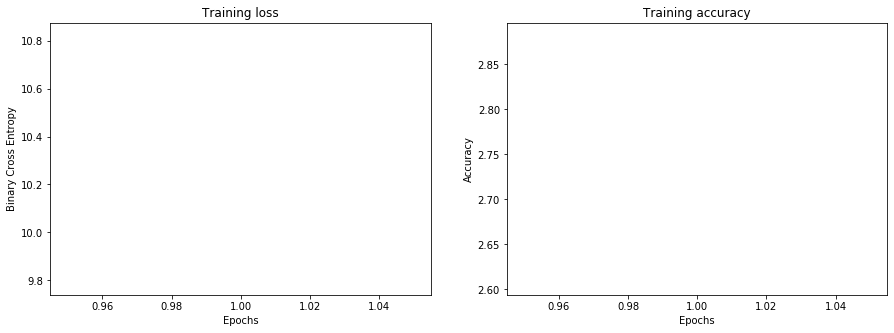

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

plt.plot(range(1, EPOCHS+1), tr_loss1)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc1)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Last test accuracy :0.658


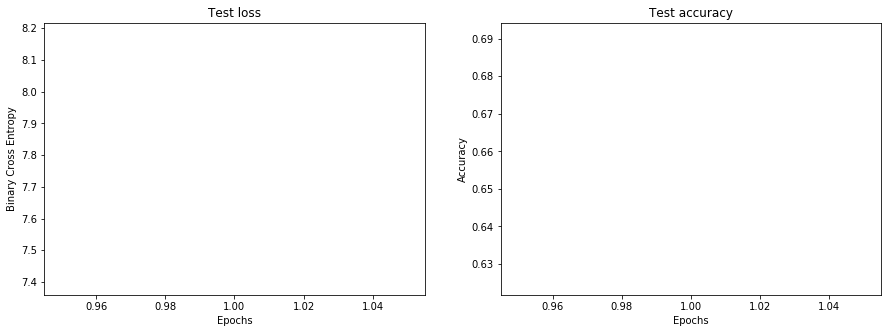

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

plt.plot(range(1, EPOCHS+1), te_loss1)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS+1), te_acc1)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

print("Last test accuracy :" + str(te_acc1[-1]))